Reference: https://github.com/twitterdev/do_more_with_twitter_data/blob/master/examples/timeseries/timeseries.ipynb

In [6]:
import datetime
import functools
import itertools
from pathlib import Path
from timeit import default_timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *
from timeseries_utils import *

In [7]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook
plt.style.use("bmh")

pd.options.display.float_format = '{:.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Timeseries

In [8]:
users = UsersData('../data/users')
tweets = TweetsData('../data/tweets')

In [9]:
tweets_df = tweets.df.loc[:][:]
tweets_df['campaign'].value_counts()

iran202012       560571
armenia202012     72960
IRA202012         68914
GRU202012         26684
Name: campaign, dtype: Int64

In [10]:
df = tweets_df.loc[:][tweets_df['campaign'] == 'iran202012']
len(df)

560571

In [11]:
campaign_start = min(tweets_df['tweet_time'])
campaign_end = max(tweets_df['tweet_time'])
campaign_period = campaign_end - campaign_start

print(campaign_start)
print(campaign_end)
print(campaign_period)

2009-07-06 06:39:00
2020-12-27 22:55:00
4192 days 16:16:00


In [12]:
campaign_years = campaign_period / np.timedelta64(1, "Y")
campaign_years

11.479161865822784

In [13]:
def resample_ts(df, freq):
    return (df
             .set_index('tweet_time')
             .resample(freq)
             .size()
             .reset_index()
             .rename(columns={0:'per_{}_count'.format(freq)})
             .set_index('tweet_time')
            )

<IPython.core.display.Javascript object>


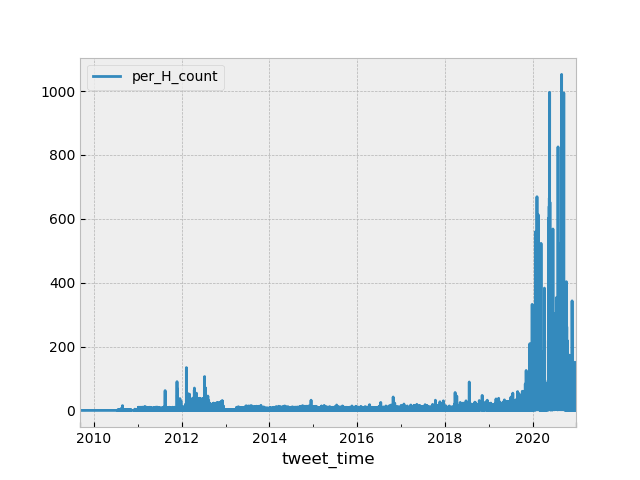

In [14]:
hourly = resample_ts(df, 'H')
hourly.plot()

<IPython.core.display.Javascript object>


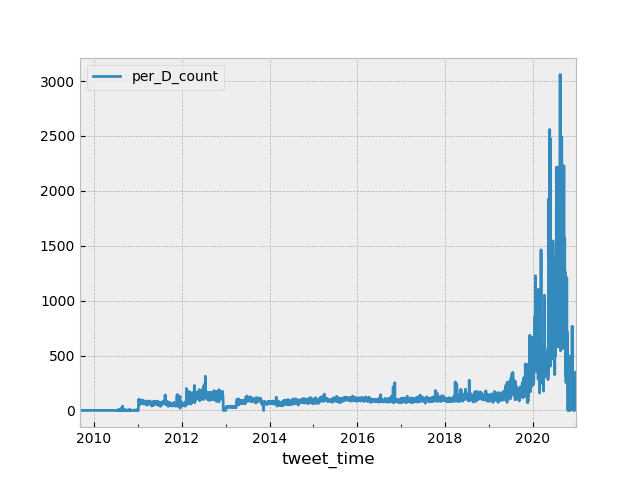

In [15]:
daily = resample_ts(df, 'D')
daily.plot()

In [16]:
print("total tweets counted: {}\n".format(hourly
                                          .sum()
                                         )
     )
print('hourly tweets:\n{}'.format(hourly
                                 .describe()
                                 .astype('int')
                                )
     )

total tweets counted: per_H_count    560571
dtype: int64

hourly tweets:
       per_H_count
count        99126
mean             5
std             17
min              0
25%              2
50%              3
75%              5
max           1052


<IPython.core.display.Javascript object>


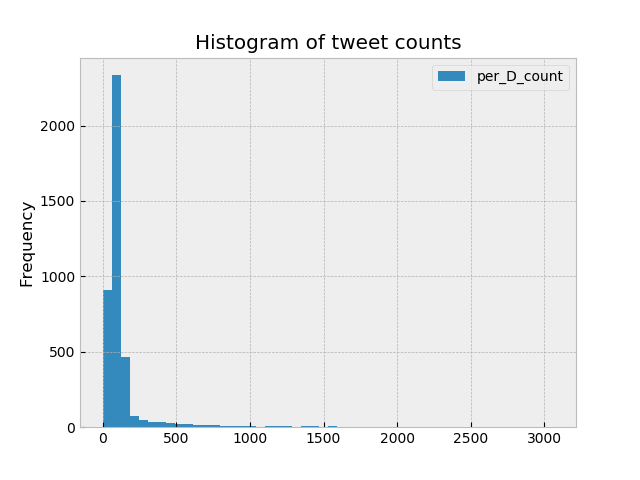

In [17]:
(daily
 .plot.hist(bins=50, title="Histogram of tweet counts")
)

## Differencing

In [18]:
def standardize(df):
    return (df - df.mean()) / df.std()

In [19]:
daily_diff = (daily
             .diff()
             )
daily_std_diff = (daily
             .pipe(standardize)
             .diff()
            )

In [20]:
print(daily_diff
      .describe()
      .loc[['mean','std','min','max']]
)
print('\nstandardized:\n',
        daily_std_diff
         .describe()
         .loc[['min','max']]
)

      per_D_count
mean         0.01
std        115.87
min      -1965.00
max       1844.00

standardized:
      per_D_count
min        -8.54
max         8.01


<IPython.core.display.Javascript object>


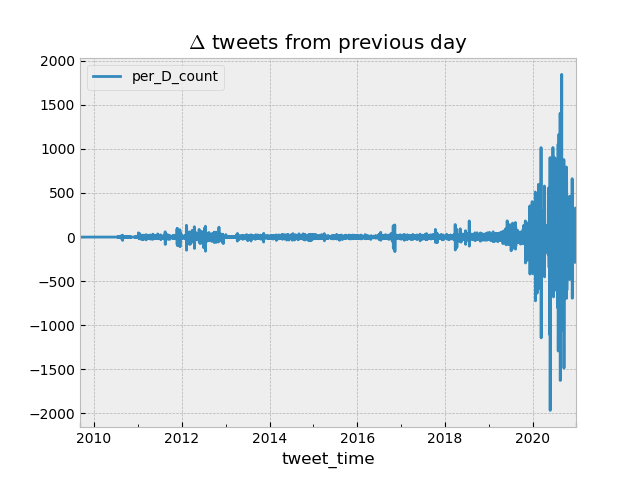

In [21]:
daily_diff.plot(title="$\Delta$ tweets from previous day")

In [23]:
hourly_diff = (hourly
              .diff()
              )

hourly_std_diff = (hourly
                     .pipe(standardize)
                     .diff()
                    )

<IPython.core.display.Javascript object>


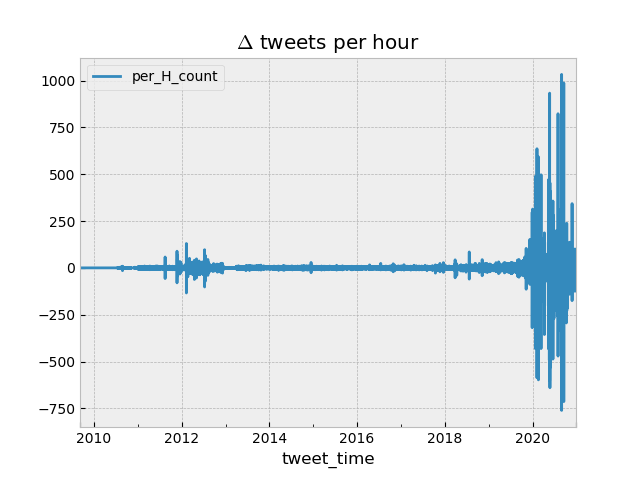

In [24]:
hourly_diff.plot(title="$\Delta$ tweets per hour")

<IPython.core.display.Javascript object>


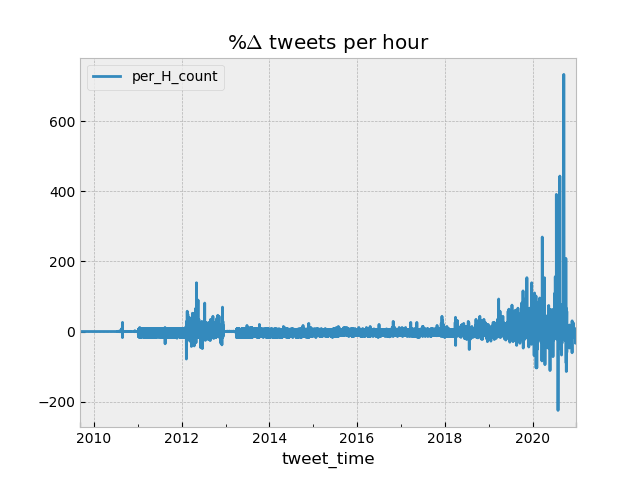

In [25]:
(hourly
 .pipe(standardize)
 .pct_change()
).plot(title="%$\Delta$ tweets per hour")

## Rolling statistics

<IPython.core.display.Javascript object>


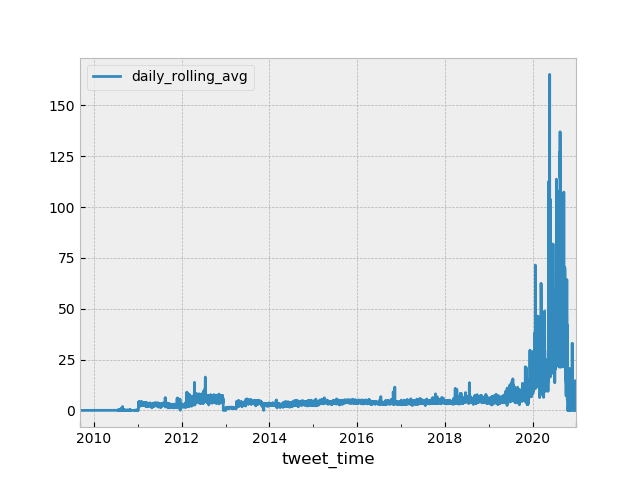

In [51]:
(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count':'daily_rolling_avg',
                  'tweet_time':'time'})
 .fillna(0)
).plot()

<IPython.core.display.Javascript object>


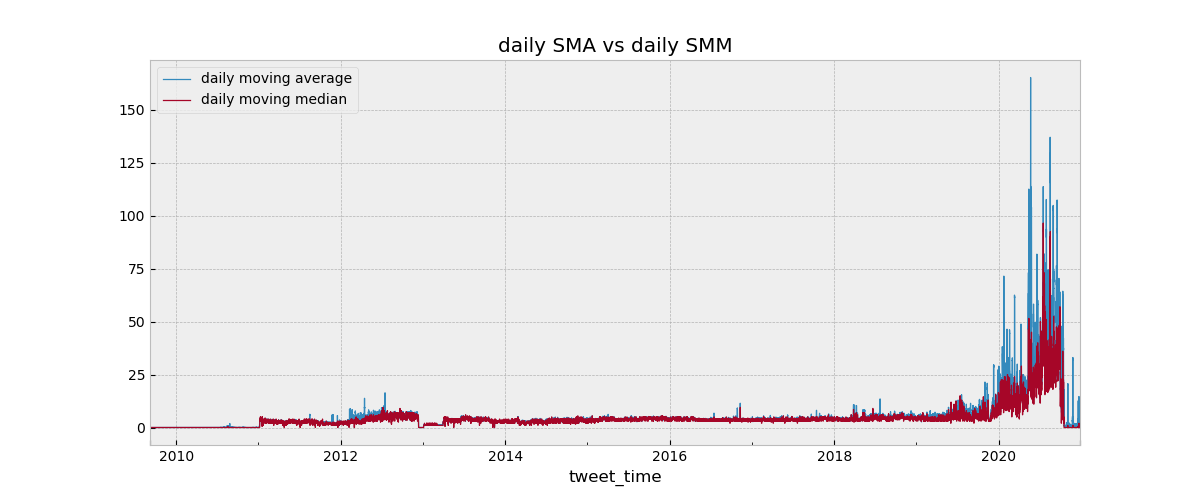

In [49]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count': 'daily moving average'})
 .plot(ax=axes, lw=0.9));

(hourly
 .rolling(24)
 .median()
 .rename(columns={'per_H_count': 'daily moving median'})
 .plot(ax=axes, lw=0.9));

axes.set_title(label="daily SMA vs daily SMM");